In [1]:
import re
import random
import os
import zipfile
import sys
import time
import glob

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 10)
import seaborn as sns

from PIL import Image
from tensorflow import keras
from sklearn.utils import class_weight
# TensorFlow Keras
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization, Lambda, Concatenate
from keras.models import Model, Sequential, load_model
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = '/content/drive/MyDrive/PracticaImagenes/garbage_classification'
train_dir = '/content/drive/MyDrive/PracticaImagenes/garbage_classification/train'
test_dir = '/content/drive/MyDrive/PracticaImagenes/garbage_classification/test'
val_dir = '/content/drive/MyDrive/PracticaImagenes/garbage_classification/validation'

In [4]:
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

In [5]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

def imagepaths_df(directory):
  # list conatining all the filenames in the dataset
  filenames_list = []
  # list to store the corresponding category, note that each folder of the dataset has one class of data
  categories_list = []

  for category in categories:
      filenames = os.listdir(directory + "/" + categories[category])
      
      filenames_list = filenames_list  +filenames
      categories_list = categories_list + [category] * len(filenames)
      
  df = pd.DataFrame({
      'filename': filenames_list,
      'category': categories_list
  })

  df = add_class_name_prefix(df, 'filename')
  # Shuffle the dataframe
  df = df.sample(frac=1).reset_index(drop=True)
  print('number of elements in train = ' , len(df))
  return(df)

def viz_class_distribution(df):
  df_visualization = df.copy()
  # Change the catgegories from numbers to names
  df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

  df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

  plt.xlabel("Garbage Classes", labelpad=14)
  plt.ylabel("Images Count", labelpad=14)
  plt.title("Count of images per class", y=1.02)

In [ ]:
print("TRAIN ")
df_train = imagepaths_df(train_dir)
print("TEST ")
df_test = imagepaths_df(test_dir)
print("VALIDATION ")
df_val = imagepaths_df(val_dir)

TRAIN 
number of elements in train =  39624
TEST 
number of elements in train =  3103
VALIDATION 
number of elements in train =  6678


## Distribucion antes de data augmentation
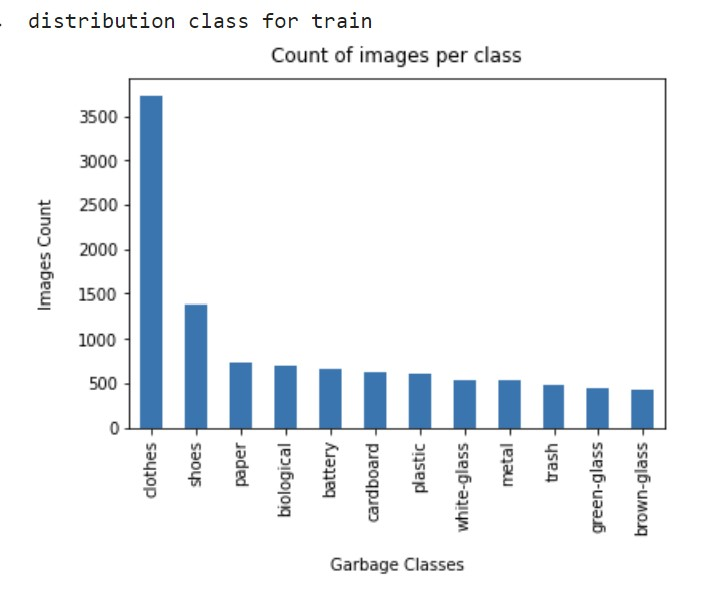

distribution class for train


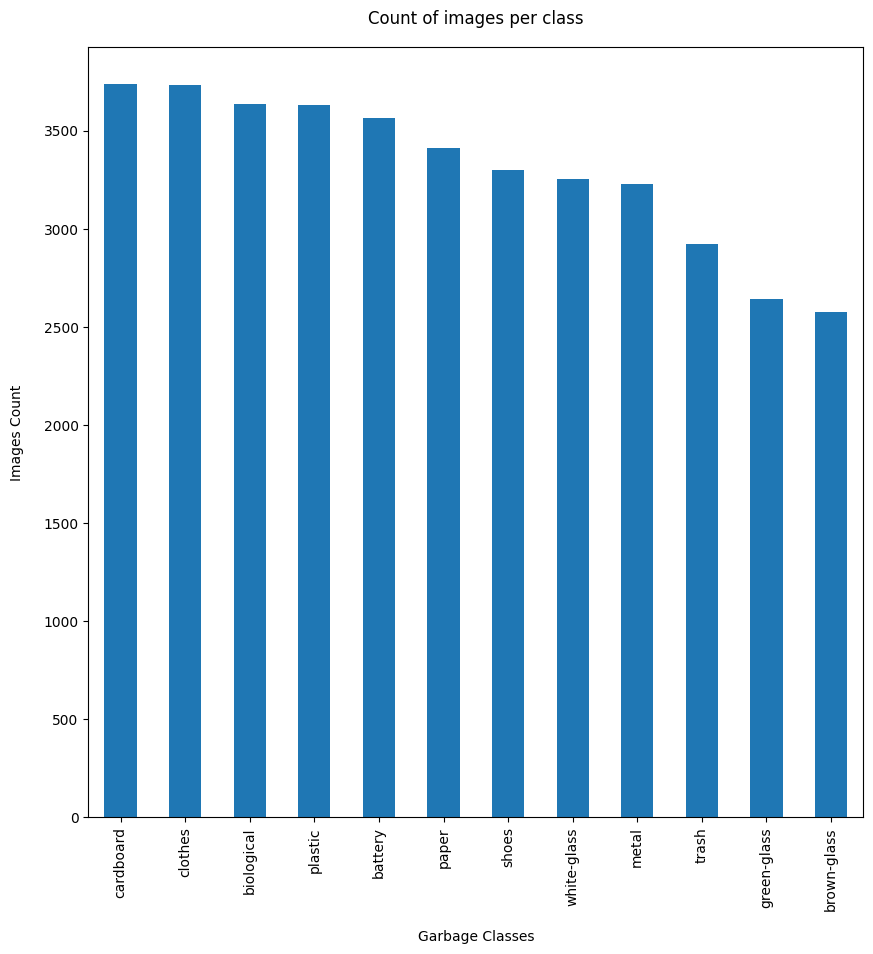

In [ ]:
print("distribution class for train")
viz_class_distribution(df_train)

In [ ]:
# Para eliminar imagenes
# import os
# from google.colab import drive

# directory_path = '/content/drive/MyDrive/PracticaImagenes/garbage_classification/train/shoes' 
# n = 500

# # Get the file names in the directory
# file_names = os.listdir(directory_path)
# file_names.sort(key=lambda x: os.path.getctime(os.path.join(directory_path, x)))  # Sort the file names by creation time

# # Delete the last n files
# for i in range(n):
#     file_path = os.path.join(directory_path, file_names[-1-i])
#     if os.path.isfile(file_path):
#         os.remove(file_path)
#         # print(f"Deleted file: {file_path}")
#     else:
#         print(f"Could not delete file: {file_path}")

In [ ]:
train_dir

'/content/drive/MyDrive/PracticaImagenes/garbage_classification/train'

metal649_0_8330.jpeg


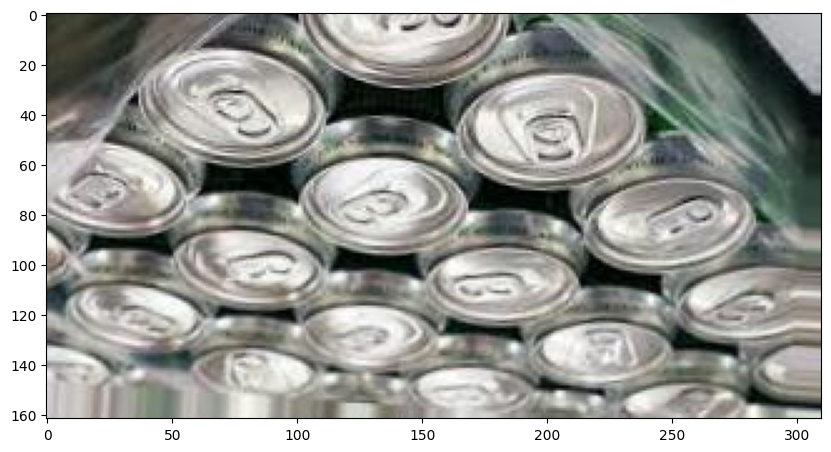

In [ ]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df_train)-1)
sampledir = df_train.iloc[random_row]['filename'].split("/")[0]
sample = df_train.iloc[random_row]['filename'].split("/")[1]
print(sample)
randomimage = image.load_img(train_dir + "/" + sampledir + "/" + sample)
plt.imshow(randomimage)

## 2.-Modelo sin balanceo de clases

In [ ]:
# Hacemos data augmentation en las 12 clases
train_datagen = image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 256x256 pixels
    batch_size=32,
    class_mode='categorical' 
)

test_datagen = image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

### Definimos la arquitectura del modelo. Ponemos menos filtros en las capas iniciales ya que al inicio el modelo se encarga de sacar features mas generales por lo que no necesita gran cantidad de filtros; mientras en capas mas produnfas el modelo extrae features mucho mas abstractos y especiifcos por lo tanto requerimos de mas filtros. Asimismo, tener menos filtros en las capas iniciales del modelo ayuda a reducir la dimensionalidad de la entrada reduciendo el esfuerzo computacional requerido para procesar estas  imagenes. Asimismo, agregamos dropout al 10% para evitar el sobreentrenamiento; esto lo que hara es limitar las conexiones que unen las 2 capas. En este caso el 10% de las neuronas no se van  a poder utilziar en esa pasada, por lo tanto la red se va a ver obligada a cada vez descrubirir nuevas caracteristicas.

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.10), 
    Dense(12, activation='softmax')
])

In [ ]:
train_loss, train_acc = model.evaluate(train_generator, steps=train_generator.n // train_generator.batch_size)
print('Train loss:', train_loss)
print('Train accuracy:', train_acc)

339/339 [==============================] - 4280s 13s/step - loss: 0.8209 - accuracy: 0.7235
Train loss: 0.8209327459335327
Train accuracy: 0.7234513163566589


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

96/96 [==============================] - 1158s 12s/step - loss: 0.7432 - accuracy: 0.7578
Test loss: 0.7431825995445251
Test accuracy: 0.7578125


In [ ]:
# Imprime un resumen de la arquitectura de la CNN
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [ ]:
# Generate predictions for the test set
y_pred = model.predict(test_generator, steps=len(test_generator))

97/97 [==============================] - 83s 844ms/step


In [ ]:
# Get true labels of test data
y_test_classes = test_generator.classes
y_test_labels = test_generator.labels

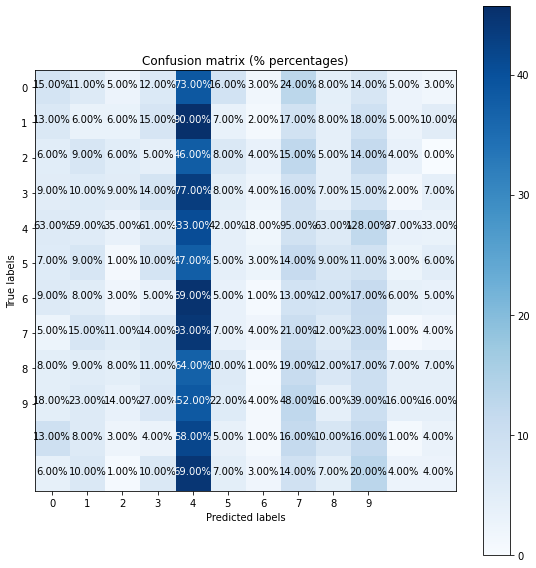

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

# Convert counts to percentages
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
im = plt.imshow(cm_perc, cmap=plt.cm.Blues)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix (% percentages)")
plt.colorbar(im)

# Annotate each cell with its value
thresh = cm_perc.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if cm_perc[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
y_test = keras.utils.to_categorical(y_test_labels, len(categories))
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
y_pred[:, 0]

array([5.6370795e-06, 7.5355828e-02, 8.5516721e-01, ..., 5.0133509e-03,
       4.7045364e-06, 4.7371222e-07], dtype=float32)

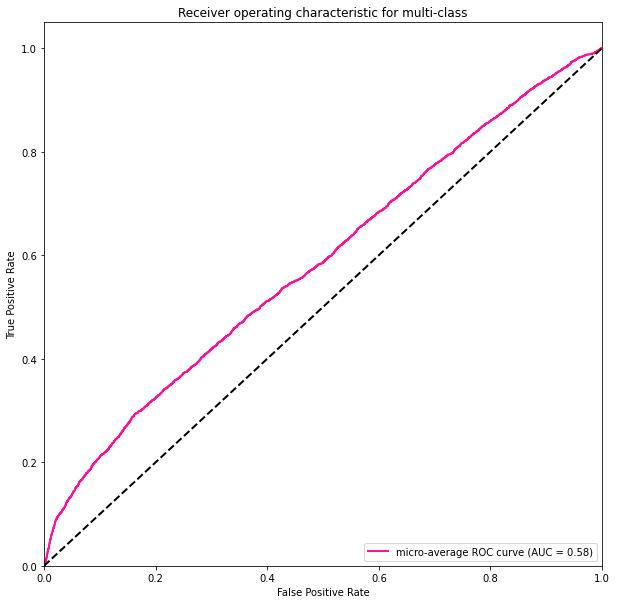

In [ ]:
# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves for each class and the micro-average
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink',
         lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                ''.format(roc_auc["micro"]))
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan', 'magenta', 'black']
# for i, color in zip(range(len(categories)), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (AUC = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")

plt.show()


## 3.-Realizamos Data Augmentation solo a las clases minoritaras  

Originalmente el dataset se encontraba bastante desbalanceado, una clase con 3500 imagenes y el resto con 200 aproximandamete. Ajustamos el modelo con el dataset original, haciendo data augmentation a todas las clases y vimos que este generalizaba muy mal; por ello, decidimos realizar como paso previo data augmentation unicamente a las 11 clases minoritarias. Otras opciones que hubiesen funcionado para manejar las clases desbalanceadas son downsampling (de por si ya teniamos pocas imagenes), ponderacion de clases o class weights o transfer learning (lo aplicaremos más adelante)

In [ ]:
# Definimos las clases desbalanceadas
imbalancedClasses = [dir for dir in categories.values() if dir != 'clothes']

# Define data augmentation parameters
train_datagen_for_augmentation = image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Iterate over subdirectories (classes) in the main directory
for classes in imbalancedClasses:
    sub_dir_path = os.path.join(train_dir, classes)
    if os.path.isdir(sub_dir_path):
        print(f"Augmenting images in directory: {sub_dir_path}")
        
        # Iterate over images in the subdirectory and perform augmentation
        for img_file in os.listdir(sub_dir_path):
            img_path = os.path.join(sub_dir_path, img_file)
            if os.path.isfile(img_path):
                img = Image.open(img_path)
                
                # Convert image to grayscale
                img_gray = img.convert('RGB')
                
                img_arr = np.array(img_gray)  # Convert image to numpy array
                img_arr = img_arr.reshape((1,) + img_arr.shape)  # Add batch and channel dimensions
                
                i = 0
                # Generate and save augmented images
                for batch in train_datagen_for_augmentation.flow(img_arr, batch_size=32, save_to_dir=sub_dir_path, save_prefix=img_file.split('.')[0], save_format='jpeg'):
                    i += 1
                    if i >= 5:  # Generate 5 augmented images for each original image
                        break

Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/paper
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/cardboard
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/plastic
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/metal
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/trash
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/battery
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/shoes
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/green-glass
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/train/brown-glass
Augmenting images

distribution class for train


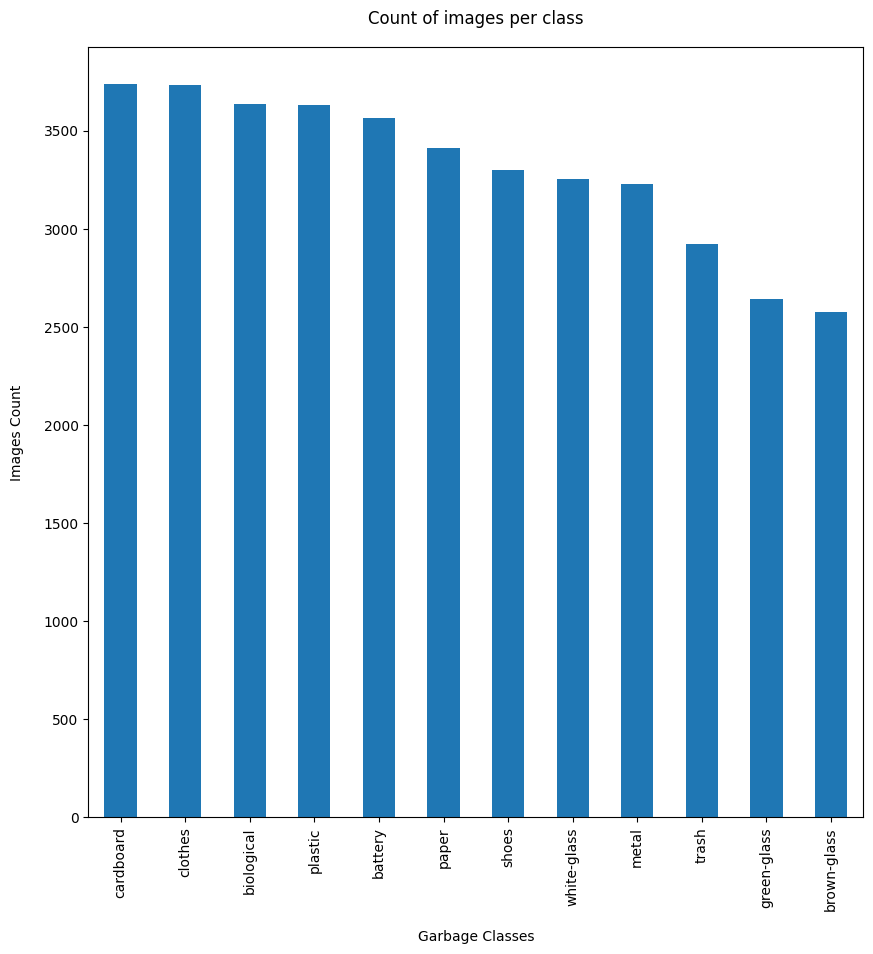

In [ ]:
print("distribution class for train")
viz_class_distribution(df_train)

In [ ]:
# Definimos las clases desbalanceadas
imbalancedClasses = [dir for dir in categories.values() if dir != 'clothes']

# Define data augmentation parameters
val_datagen_for_augmentation = image.ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Define desired number of images
desired_num_images = 1000

# Iterate over subdirectories (classes) in the main directory
for classes in imbalancedClasses:
    sub_dir_path = os.path.join(val_dir, classes)
    if os.path.isdir(sub_dir_path):
        print(f"Augmenting images in directory: {sub_dir_path}")
        
        # Count number of images in the subdirectory
        num_images = len(os.listdir(sub_dir_path))
        
        # Calculate number of augmented images needed to reach desired number
        num_augmented_images_needed = desired_num_images - num_images
        
        # Perform data augmentation until desired number of images is reached
        i = 0
        while i < num_augmented_images_needed:
            for img_file in os.listdir(sub_dir_path):
                img_path = os.path.join(sub_dir_path, img_file)
                if os.path.isfile(img_path):
                    img = Image.open(img_path)
                
                    # Convert image to grayscale
                    img_gray = img.convert('RGB')
                
                    img_arr = np.array(img_gray)  # Convert image to numpy array
                    img_arr = img_arr.reshape((1,) + img_arr.shape)  # Add batch and channel dimensions
                
                    # Generate and save augmented images
                    for batch in val_datagen_for_augmentation.flow(img_arr, batch_size=32, save_to_dir=sub_dir_path, save_prefix=img_file.split('.')[0], save_format='jpeg'):
                        i += 1
                        if i >= num_augmented_images_needed:
                            break
                    if i >= num_augmented_images_needed:
                        break

Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/paper
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/cardboard
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/plastic
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/metal
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/trash
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/battery
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/shoes
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classification/validation/green-glass
Augmenting images in directory: /content/drive/MyDrive/PracticaImagenes/garbage_classifica

In [ ]:
import os
from google.colab import drive

def delete_last_n_files(dir_path, n):
    
    # Get the file names in the directory
    file_names = os.listdir(dir_path)
    file_names.sort(key=lambda x: os.path.getctime(os.path.join(dir_path, x)))  # Sort the file names by creation time
 
    # Delete the last n files
    for i in range(n):
        file_path = os.path.join(dir_path, file_names[-1-i])
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
        else:
            print(f"Could not delete file: {file_path}")

In [ ]:
for imbalancedclass in imbalancedClasses:
  path = os.path.join(val_dir,imbalancedclass)
  n = 370
  delete_last_n_files(path, 370)

distribution class for val


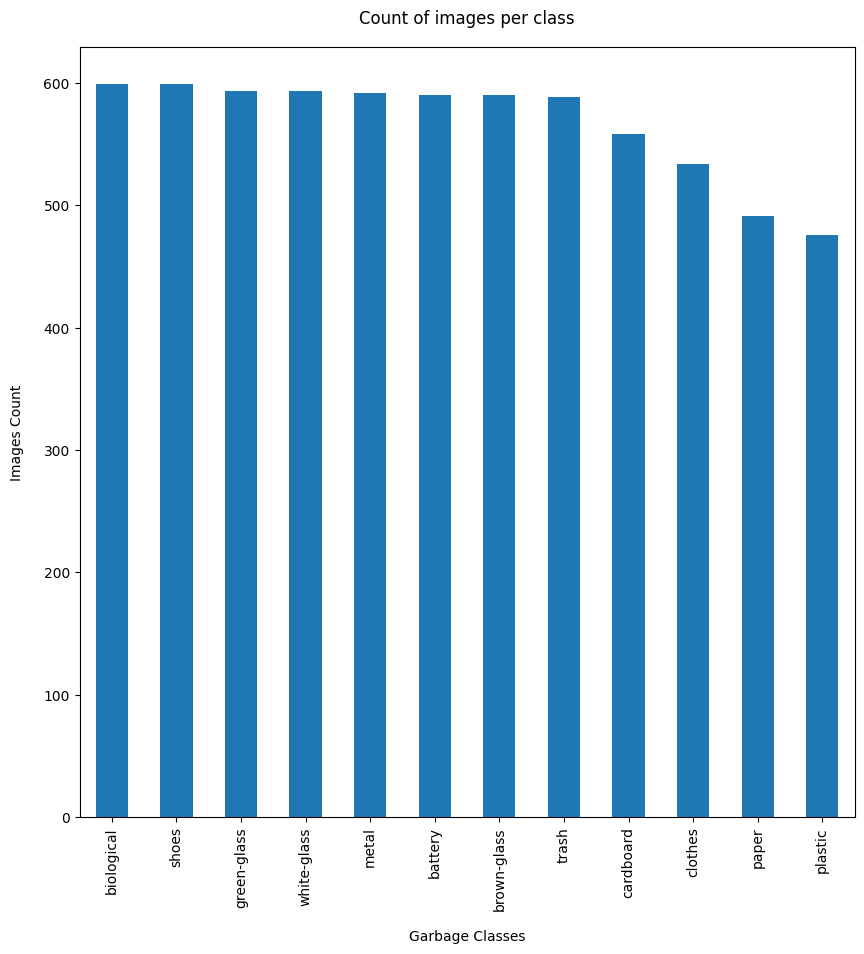

In [ ]:
print("distribution class for val")
viz_class_distribution(df_val)

## 4.- Red con clases balanceadas

Entrenamos la misma red pero ahora en el ImageDataGenerator solo normalizamos los pixeles de las imagenes.

In [6]:
# Prepare the images to feed the model
train_datagen = image.ImageDataGenerator(rescale=1./255)  # Normalize pixel values

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical' 
)

test_datagen = image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = image.ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 39624 images belonging to 12 classes.
Found 3103 images belonging to 12 classes.
Found 6678 images belonging to 12 classes.


In [7]:
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.10), # se usa para evitar que la red sobreaprenda: las conexiones que unen las 2 capas, el 20% de las conexiones de esas 2 capas no las va a poder utilziar para esa pasada (cada vez va a tener que descrubiri nuevas caracteristicas)
    Dense(12, activation='softmax')
])

In [ ]:
checkpoint_path = "/content/drive/MyDrive/PracticaImagenes/checkpoints/model2_epochweights.h5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch'
)

# Compile the model with the same settings as the original model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model2.fit(
    train_generator,
    steps_per_epoch=339,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[checkpoint],
    verbose = 1
)

In [ ]:
# Guardamos la arquitectura del modelo y los pesos
model2.save('/content/drive/MyDrive/PracticaImagenes/checkpoints/model2.h5')
model2.save_weights('/content/drive/MyDrive/PracticaImagenes/checkpoints/model2_weights.h5')

### Resume Training

In [8]:
# Load the saved model checkpoint
model2.load_weights('/content/drive/MyDrive/PracticaImagenes/checkpoints/model2v2final_weights.h5')
# checkpoint_weights = "/content/drive/MyDrive/PracticaImagenes/checkpoints/model2_weights.h5"

In [ ]:
checkpoint_path = "/content/drive/MyDrive/PracticaImagenes/checkpoints/model2_weights.h5"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch'
)


# Compile the model
model2.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

history = model2.fit(
    train_generator,
    steps_per_epoch=339,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[checkpoint],
    verbose = 1
)

In [ ]:
# Guardamos la arquitectura del modelo y los pesos
model2.save('/content/drive/MyDrive/PracticaImagenes/checkpoints/model2v2.h5')
model2.save_weights('/content/drive/MyDrive/PracticaImagenes/checkpoints/model2v2final_weights.h5')

In [ ]:
# Imprime un resumen de la arquitectura de la CNN
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [ ]:
test_loss, test_acc = model2.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

96/96 [==============================] - 714s 8s/step - loss: 0.7511 - accuracy: 0.7702
Test loss: 0.7511381506919861
Test accuracy: 0.7701823115348816


In [ ]:
# Generate predictions for the test set
y_pred = model2.predict(test_generator, steps=len(test_generator))

# Get true labels of test data
y_test_classes = test_generator.classes
y_test_labels = test_generator.labels

97/97 [==============================] - 90s 912ms/step


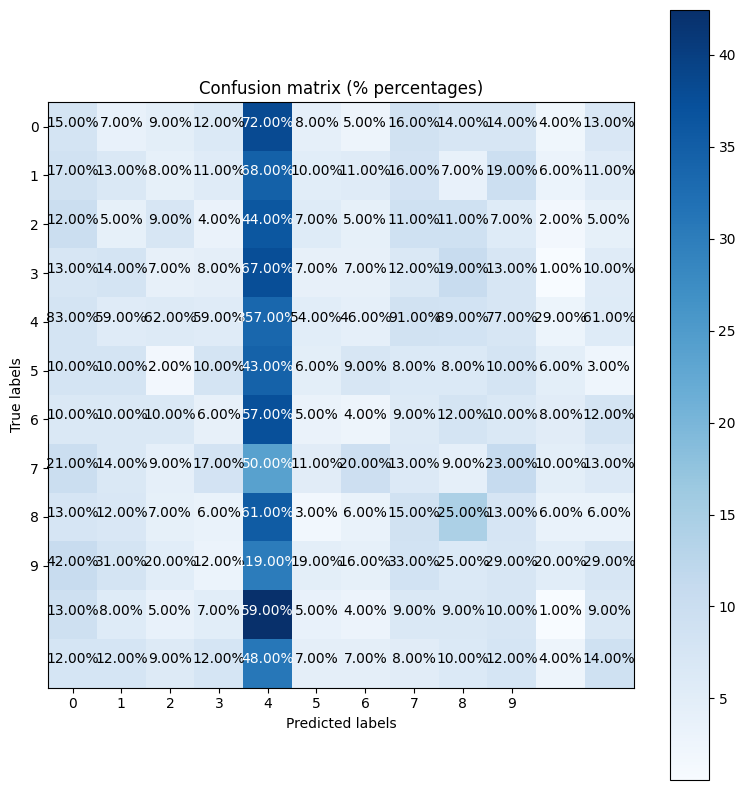

In [ ]:

# Calculate the confusion matrix
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

# Convert counts to percentages
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
im = plt.imshow(cm_perc, cmap=plt.cm.Blues)
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix (% percentages)")
plt.colorbar(im)

# Annotate each cell with its value
thresh = cm_perc.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f') + '%',
                 horizontalalignment="center",
                 color="white" if cm_perc[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

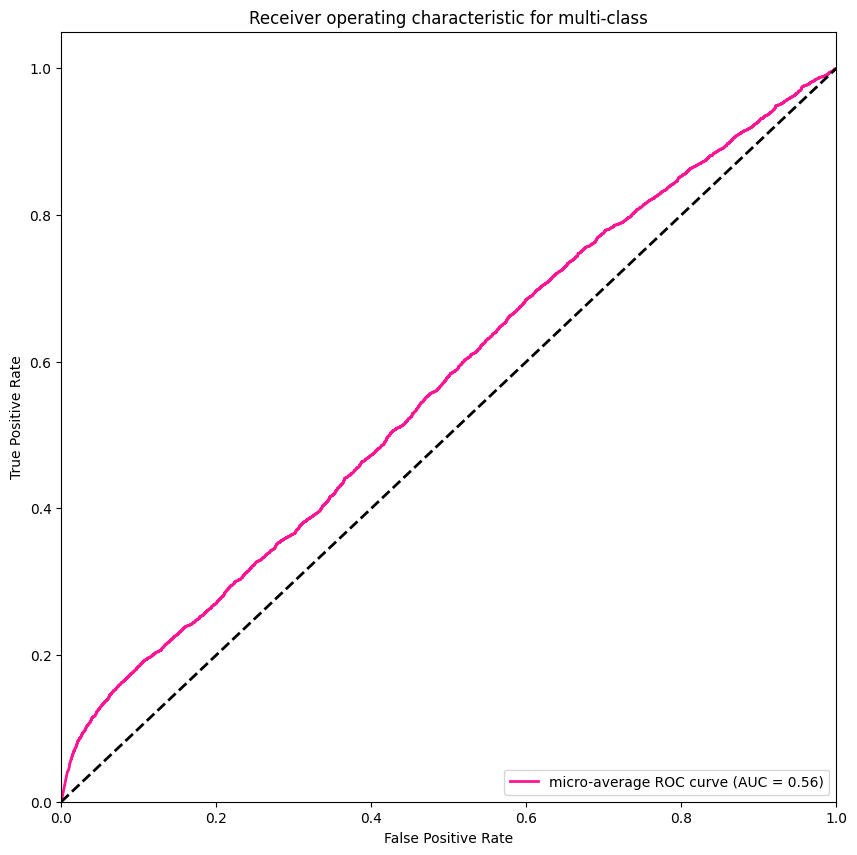

In [ ]:
y_test = keras.utils.to_categorical(y_test_labels, len(categories))
# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves for each class and the micro-average
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='deeppink',
         lw=lw, label='micro-average ROC curve (AUC = {0:0.2f})'
                ''.format(roc_auc["micro"]))
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan', 'magenta', 'black']
# for i, color in zip(range(len(categories)), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (AUC = {1:0.2f})'
#              ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")

plt.show()